In [2]:
import os
# os.chdir('../')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from multipy.fwer import sidak, hochberg
import random

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence
from utils.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

<module 'utils.viz_utils' from '/home/ekvlasova/tcr-covid-classifier/utils/viz_utils.py'>

In [3]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [4]:
desc = pd.read_csv('data/desc_fmba_not_nan_hla.csv').drop(columns=['Unnamed: 0'])
desc = desc[desc.COVID_status != 'unknown']
desc['covid'] = desc.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc

,run,reads,clonotypes,singletons,doubletons,file.id,sequencingDate,folder,R1,R2,...,HLA-DRB1.1,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,is.bad.reseq,covid
0,020000010808_S3_L001.clonotypes.TRB.txt,623811,4324,491,263,020000010808_S3_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000010808_S3_L001_R1_001.fastq.gz,020000010808_S3_L001_R2_001.fastq.gz,...,DRB1*11:04,DRB1*16:01,20000010,NaN,NaN,NaN,NaN,TRB,NaN,covid
1,020000110808_S14_L001.clonotypes.TRB.txt,13119545,13264,573,219,020000110808_S14_L001,2020 09 05,2020/09_FMBA_NovaSeq_DNA,020000110808_S14_L001_R1_001.fastq.gz,020000110808_S14_L001_R2_001.fastq.gz,...,DRB1*01:01,DRB1*15:01,20000110,NaN,NaN,NaN,NaN,TRB,NaN,covid
2,020000190808_S27_L001.clonotypes.TRB.txt,6942203,16977,1198,550,020000190808_S27_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000190808_S27_L001_R1_001.fastq.gz,020000190808_S27_L001_R2_001.fastq.gz,...,DRB1*07:01,DRB1*15:02,20000190,NaN,NaN,NaN,NaN,TRB,NaN,covid
3,020000200808_S181_L002.clonotypes.TRB.txt,6583555,14220,916,420,020000200808_S181_L002,2020 10 19,2020/10_FMBA_NovaSeq5,020000200808_S181_L002_R1_001.fastq.gz,020000200808_S181_L002_R2_001.fastq.gz,...,DRB1*01:01,DRB1*04:04,20000200,NaN,NaN,NaN,NaN,TRB,NaN,healthy
4,020000280808_S59_L001.clonotypes.TRB.txt,2005779,6144,477,260,020000280808_S59_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000280808_S59_L001_R1_001.fastq.gz,020000280808_S59_L001_R2_001.fastq.gz,...,DRB1*01:03,DRB1*13:03,20000280,NaN,NaN,NaN,NaN,TRB,NaN,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780008510808_S152_L002.clonotypes.TRB.txt,125864,7215,1173,793,780008510808_S152_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008510808_S152_L002_R1_001.fastq.gz,780008510808_S152_L002_R2_001.fastq.gz,...,DRB1*07:01,DRB1*15:01,780008510,NaN,NaN,NaN,NaN,TRB,NaN,covid
952,780008550808_S150_L002.clonotypes.TRB.txt,3070841,8864,398,150,780008550808_S150_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008550808_S150_L002_R1_001.fastq.gz,780008550808_S150_L002_R2_001.fastq.gz,...,DRB1*04:01,DRB1*15:01,780008550,NaN,NaN,NaN,NaN,TRB,NaN,covid
953,910000140808_S123_L002.clonotypes.TRB.txt,3095012,27443,1318,643,910000140808_S123_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000140808_S123_L002_R1_001.fastq.gz,910000140808_S123_L002_R2_001.fastq.gz,...,DRB1*03:01,DRB1*07:01,910000140,NaN,NaN,NaN,NaN,TRB,NaN,covid
954,910000320808_S121_L002.clonotypes.TRB.txt,203560,11451,2013,1299,910000320808_S121_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000320808_S121_L002_R1_001.fastq.gz,910000320808_S121_L002_R2_001.fastq.gz,...,DRB1*01:02,DRB1*07:01,910000320,NaN,NaN,NaN,NaN,TRB,NaN,covid


# β chain biomarkers postprocessing

In [5]:
os.getcwd()

'/home/ekvlasova/tcr-covid-classifier'

In [6]:
raw_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0'])

In [7]:
raw_beta_cm

,CASARGYEQYF,CASDRGYEQYF,CASGLGGNQPQHF,CASGLGGSYEQYF,CASGLSGGNQPQHF,CASGPPYEQYF,CASKPGGSYEQYF,CASKRGYEQYF,CASMRGYEQYF,CASNLGGSYEQYF,...,CSASDRGYEQYF,CSASDSYEQYF,CSASGGGYEQYF,CSASSGHEQYF,CSASSSYEQYF,CSASTGGYEQYF,CSATDLNTEAFF,CSATSGHEQYF,GASSLSGGNQPQHF,run
0,0,0,0,0,3,1,1,0,0,0,...,0,0,0,0,0,0,0,0,2,020000010808_S3_L001.clonotypes.TRB.txt
1,2,2,3,0,0,0,0,2,2,1,...,0,0,1,0,0,0,0,0,0,020000700808_S134_L002.clonotypes.TRB.txt
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,020000360808_S102_L002.clonotypes.TRB.txt
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,270000050808_S111_L002.clonotypes.TRB.txt
4,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,050000200808_S157_L002.clonotypes.TRB.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,1,1,0,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,550001670808_S187_L002.clonotypes.TRB.txt
952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,640002920808_S23_L001.clonotypes.TRB.txt
953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,640001930808_S53_L001.clonotypes.TRB.txt
954,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,640002310808_S7_L001.clonotypes.TRB.txt


In [8]:
clean_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0'])

Preparing data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv


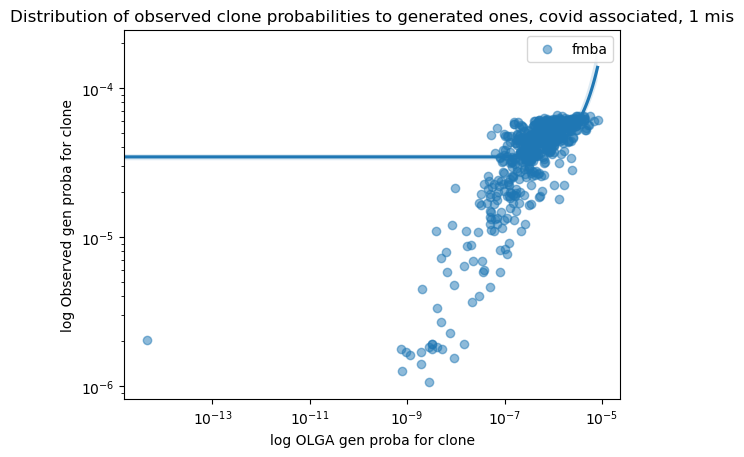

In [9]:
probas_beta = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRB_pgen.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv'], 
                                    desc='covid associated, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv', 
                                    labels=['fmba'])['fmba']

In [10]:
covid_clones_beta = clean_beta_cm.columns[1:]
res_beta = seqs2hamming(covid_clones_beta, viz_method='graphopt')

In [11]:
res_beta

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CASARGYEQYF,0,167.731968,162.464982,123,85.851304,237.854189
1,CASDRGYEQYF,0,143.001965,155.265763,123,85.851304,237.854189
2,CASKRGYEQYF,0,159.684910,174.921345,123,85.851304,237.854189
3,CASMRGYEQYF,0,146.793169,169.323642,123,85.851304,237.854189
4,CASSRGYEQYF,0,108.537857,228.282994,123,85.851304,237.854189
...,...,...,...,...,...,...,...
526,CSASDSYEQYF,57,515.857765,-40.918284,7,518.966214,-94.628174
527,CSASDRGYEQYF,58,251.836150,20.658142,1,251.836150,20.658142
528,CSASGGGYEQYF,59,358.168107,-458.548052,2,367.226784,-453.445891
529,CSASTGGYEQYF,59,376.285461,-448.343730,2,367.226784,-453.445891


In [12]:
beta_cluster_to_epi = {}
for cluster_index in range(res_beta.cluster.max()):
    beta_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_beta, cluster_index, dist=1, gene='TRB', alpha=0.05)

# α chain biomarkers postprocessing

In [13]:
clean_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0'])

In [14]:
raw_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0'])

Preparing data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv


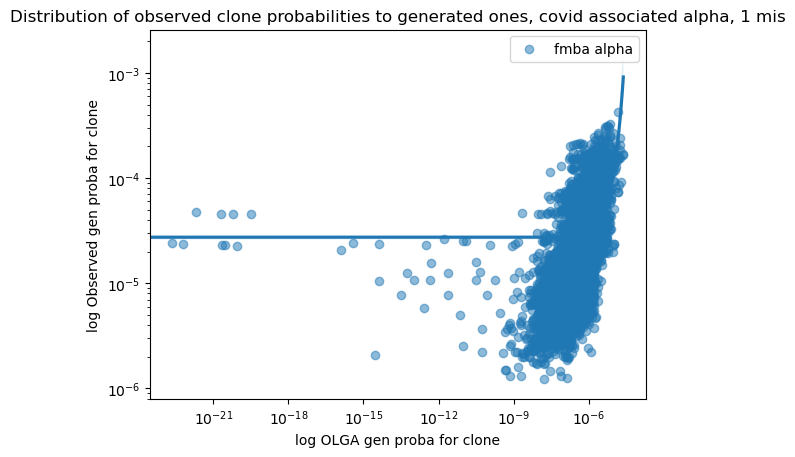

In [15]:
probas_alpha = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRA_pgen.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv'], 
                                    desc='covid associated alpha, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv', 
                                    labels=['fmba alpha'],
                                    make_bool_features=False)['fmba alpha']

In [16]:
covid_clones_alpha = clean_alpha_cm.columns[1:]
res_alpha = seqs2hamming(covid_clones_alpha, viz_method='drl')

In [17]:
res_alpha

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAAADNFNKFYF,0,-4.345153,177.853500,793,-65.221384,136.255926
1,CAAANNFNKFYF,0,-4.474837,172.973892,793,-65.221384,136.255926
2,CAAAYNFNKFYF,0,-108.172134,130.249435,793,-65.221384,136.255926
3,CAAEDNFNKFYF,0,-5.447279,180.587936,793,-65.221384,136.255926
4,CAAGDNFNKFYF,0,-28.760984,202.137863,793,-65.221384,136.255926
...,...,...,...,...,...,...,...
4090,CVVRYDSWGKLQF,139,250.805054,-191.949387,9,251.236625,-192.195882
4091,CVVSDLMEYGNKLVF,140,361.923248,-57.764977,1,361.923248,-57.764977
4092,CVVSELSGGYQKVTF,141,276.588806,-54.526127,2,276.346680,-54.419155
4093,CVVSEPSGGYQKVTF,141,276.104553,-54.312183,2,276.346680,-54.419155


In [18]:
alpha_cluster_to_epi = {}
for cluster_index in range(res_alpha.cluster.max()):
    alpha_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_alpha, cluster_index, dist=1, gene='TRA')

In [19]:
alpha_cluster_to_epi[0]

,antigen.epitope,antigen.species,count
7,GLMWLSYFI,SARS-CoV-2,4
4,FTSDYYQLY,SARS-CoV-2,16
11,MFLARGIVF,SARS-CoV-2,27
13,NQKLIANQF,SARS-CoV-2,31
18,SGPLKAEIAQRLED,InfluenzaA,33
20,VPYFNMVYM,SARS-CoV-2,50


# α, β co-occorence analysis

In [20]:
cooccurence_df = pd.read_csv('data/TRA_TRB_cooccurence_matrix_cooccurence_85.csv').T
annot_df = pd.read_csv('data/alpha_beta_paired_epitopes.csv').T

# plotting fig2

In [45]:
imported_module = importlib.import_module("utils.clustering_utils")
importlib.reload(imported_module)
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster

imported_module = importlib.import_module("utils.viz_utils")
importlib.reload(imported_module)

from utils.viz_utils import plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble

up
up
IPVAYRKVL
рррh


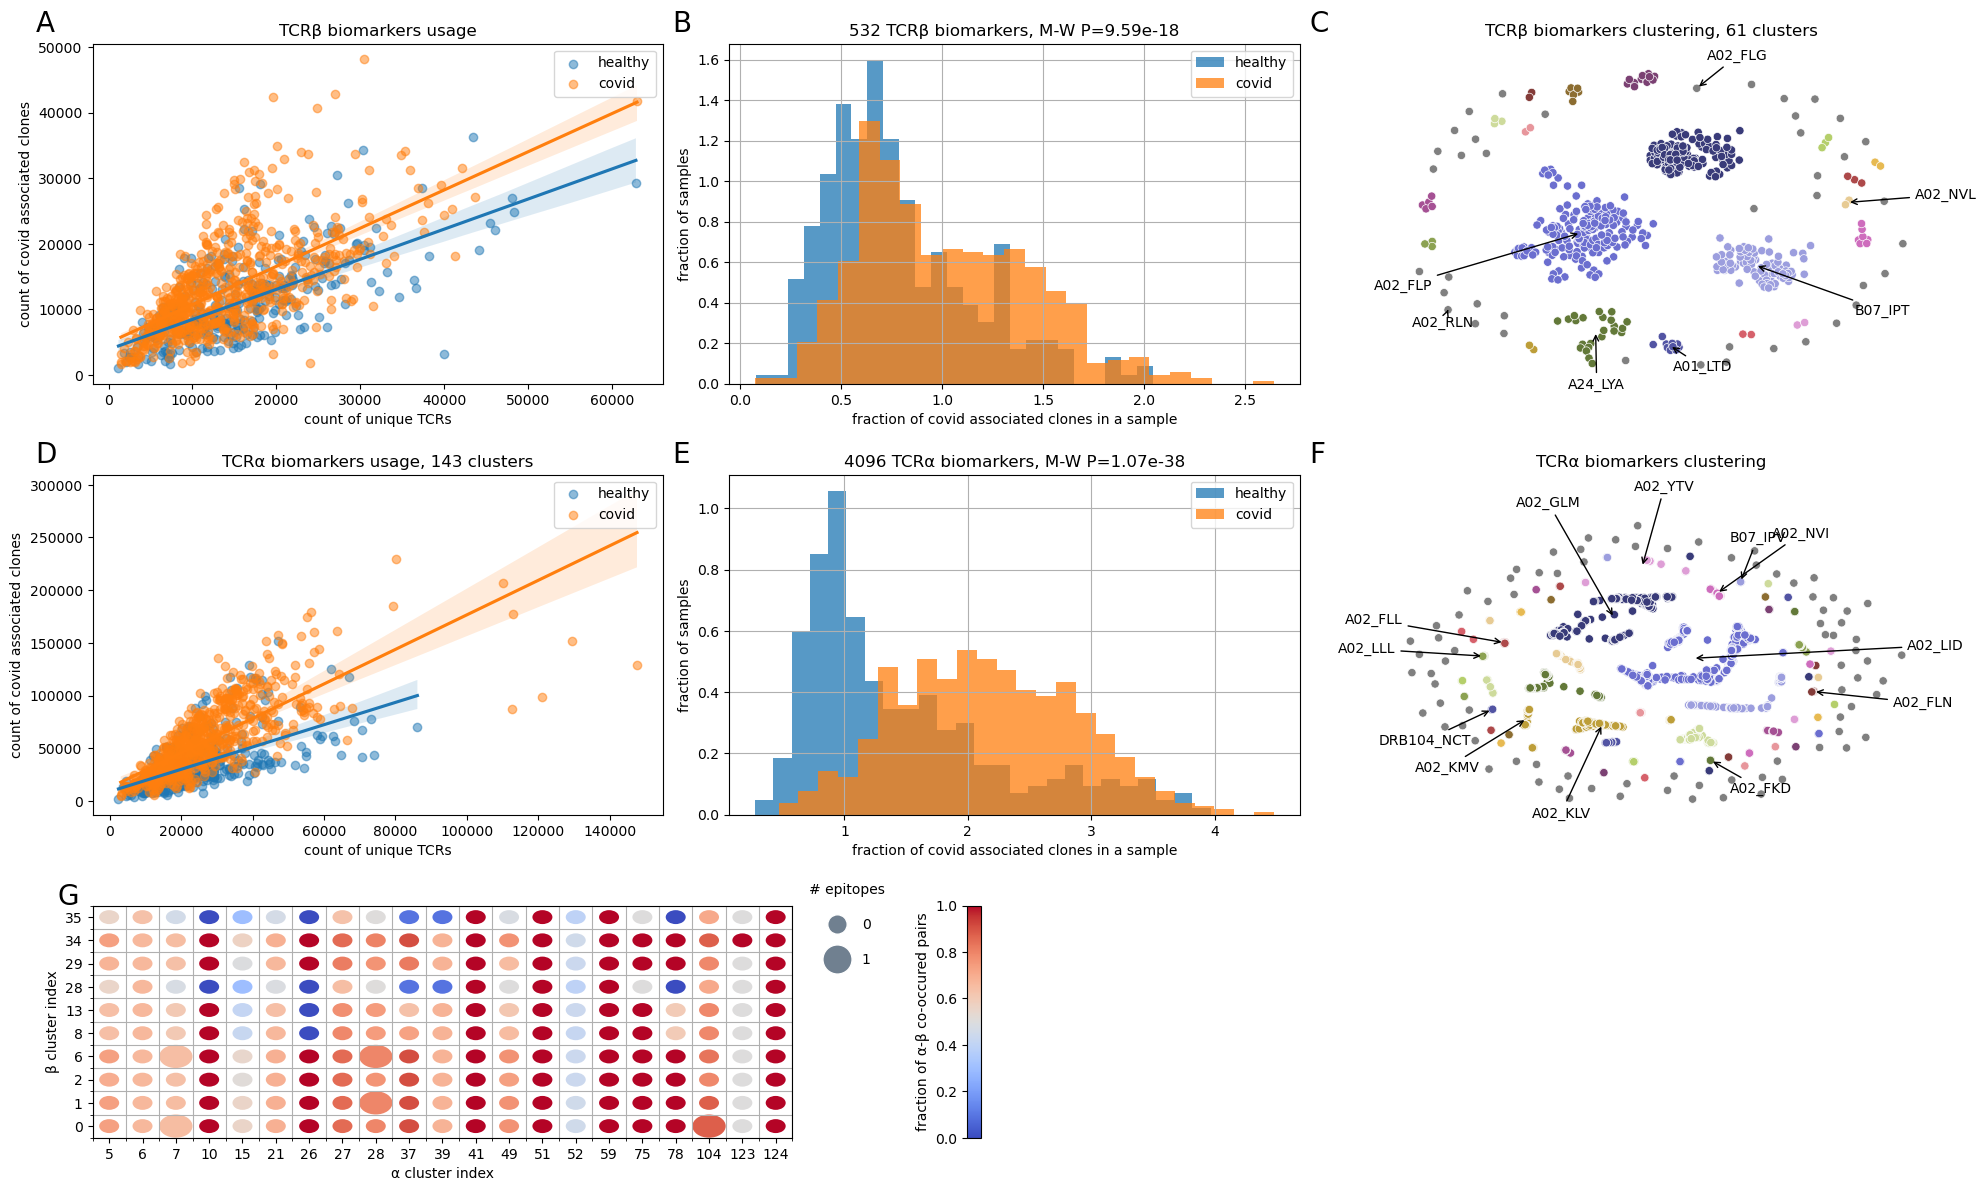

In [53]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
time = np.linspace(0, 10, 1000)
height = np.sin(time)
weight = time*0.3 + 2
score = time**2 + height
distribution = np.random.normal(0, 1, len(time))
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=11, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[:4, :2])
ax1 = fig.add_subplot(gs[:4, 2:4])
ax5 = fig.add_subplot(gs[:4, 4:])
significant_clones_distribution(significant_clonotype_matrix=clean_beta_cm, 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

# ax1.set_title('TCRβ biomarkers histogram')
ax1.legend()
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

plot_clonotype_clustering_with_epitope_labeling(res_beta, beta_cluster_to_epi, vdjdb, gene='TRB', dist_to_center=650, global_zero_based=True, ax=ax5)
ax5.set_xlim(-700, 700)
ax5.set_ylim(-700, 700)
ax5.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.legend().remove()
ax5.set_title(f'TCRβ biomarkers clustering, {res_beta.cluster.max() + 1} clusters')

####################################################

ax2 = fig.add_subplot(gs[4:8, :2])
ax3 = fig.add_subplot(gs[4:8, 2:4])
ax6 = fig.add_subplot(gs[4:8, 4:])
significant_clones_distribution(significant_clonotype_matrix=clean_alpha_cm, 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title(f'TCRα biomarkers usage, {res_alpha.cluster.max() + 1} clusters')
ax2.legend()
ax2.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

# ax3.set_title('α biomarkers histogram')
ax3.legend()
ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=450, 
                                                center_diff_threshold=75,
                                                ax=ax6)
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.axis('off')
ax6.set_xlim(-500, 500)
ax6.set_ylim(-500, 600)
ax6.legend().remove()
ax6.set_title('TCRα biomarkers clustering')
###################################################

ax7 = fig.add_subplot(gs[8:, :3])
plot_cooccurence_heatmap_with_epitopes_labeling_bubble(cooccurence_df, annot_df, fig=fig, ax=ax7, corr_threshold=4, legend_x=1.15)
ax7.text(delta_x+0.05, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################
plt.tight_layout()
plt.savefig("figures/fig2.svg")
plt.savefig("figures/fig2.pdf")
plt.savefig("figures/fig2.png")
plt.show()

Figure 2. FMBA data TCRα and TCRβ biomarkers analysis.

A, D. Scatterplots comparing the distribution of the number of COVID-associated TCRβs/TCRαs to the total number of unique TCRβs/TCRαs sampled for COVID-19 patients and healthy donors.

B, E. Distribution of the number of COVID-associated TCRβs/TCRαs showing the significant difference in COVID-19 patients/ healthy donors.

C, F. Vizualization of COVID-associated TCRβs/TCRαs based on hamming distance. The closer the points are the less the hamming distance between the CDRs is.

G. Coouccurence of CDRs in α/β clusters. Coouccurence was calculated as the percent of TCRα/TCRβ pairs which are found together in more than 80% of samples which contain either the described TCRα, or TCRβ biomarker. The number in each cell of the matrix corresponds to the number of epitopes from VDJdb, which are found to be associated with both TCRα and TCRβ clusters.

# plotting supp fig 1

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(15, 20))
gs = GridSpec(nrows=6, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[0, :2])
ax1 = fig.add_subplot(gs[0, 2:4])
significant_clones_distribution(significant_clonotype_matrix=raw_beta_cm, 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

# ax1.set_title('TCRβ biomarkers histogram')
ax1.legend()
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

ax4 = fig.add_subplot(gs[0, 4:])
plot_olga_cleanup_data(probas_beta, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax4)
ax4.set_title('TCRβ biomarkers generation probability')
ax4.legend()
ax4.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

####################################################

ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[1, 2:4])
significant_clones_distribution(significant_clonotype_matrix=raw_alpha_cm, 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title('TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

# ax3.set_title('α biomarkers histogram')
ax3.legend()
ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)


ax5 = fig.add_subplot(gs[1, 4:])
plot_olga_cleanup_data(probas_alpha, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax5)
ax5.set_title('TCRα biomarkers generation probability')
ax5.legend()
ax5.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

###################################################

plt.tight_layout()
plt.savefig("figures/supp_fig1.svg")
plt.savefig("figures/supp_fig1.pdf")
plt.show()